In [1]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
sys.path.append('../..')
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon, pearsonr
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from sklearn.model_selection import KFold
import seaborn as sns
import traceback
from itertools import product
from brokenaxes import brokenaxes
import pingouin as pg
import colorsys
from sklearn.metrics import r2_score

stim25sdecodingfilename = '..\\..\\Data\\stimdecoding_25s.csv'
passivedecodingfilename = '..\\..\\Data\\stimdecoding_25s_passive.csv'
choicedecodingfilename = '..\\..\\Data\\choicedecoding.csv'

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

TARGET_COLOR = '#ff3654'
NONTARGET_COLOR = '#5776ff'

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
SWITCH_COLOR = '#B07A3B'
LASER_COLOR = '#3375E9'
GOOD_GREY = '#969696'
GOOD_GREEN = '#32A852'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
PHASE_COLORS = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']#,'#6ded94','#50d979','#36bf5f']
STIM_COLOR = '#E8CA17'
CHOICE_COLOR = '#9DE817'

dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108']
danimals = ['DS_15','DS_19','DS_24','DS_27','DS_28']

retroanimals = ['PB_86','BS_86','PB_92','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165']
did_learn = ['BS_92','BS_103','BS_111','BS_179']
did_not_learn = ['BS_86','BS_100','BS_119','BS_123','BS_128','BS_131','BS_163','BS_174']
indeterminate = ['BS_139','BS_165','BS_191','BS_192']

dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108']#,'DS_15','DS_19']
opsinanimalnames = ['BS_86','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165','BS_174','BS_179','BS_191','BS_192']
tuninganimalnames = ['BS_173','BS_175','BS_187','BS_188','BS_213','BS_214','TH_217','AE_235','AE_236','TH_237']
unuseddualanimals = ['BS_78']
danimals = ['DS_15','DS_19','DS_24','DS_27','DS_28','DS_16','DS_17','DS_22','DS_13','DS_23']

#act_directory = 'D:\\Analysis_Cache_archived_Oct_27_2022'
act_directory = '..\\..\\Data\\Analysis_Cache'
ops_directory = '..\\..\\Data\\Opsin_Cache'
beh_directory = '..\\..\\Data\\Behavioor'

stim25sdecodingfilename = '..\\..\\Data\\stimdecoding_25s.csv'
stim25sopsinondecodingfilename = '..\\..\\Data\\stimdecoding_25s_opsin_on.csv'
stim25sopsinoffdecodingfilename = '..\\..\\Data\\stimdecoding_25s_opsin_off.csv'

current_version = 0 #June 22nd, 2023
current_version = 1 #June 29nd, 2023
current_version = 2 #July 27nd, 2023
current_version = 3 #August 12th, 2023
current_version = 4 #Nov 6th, 2023

stdfont = 14
stdyfrac = 0.06

# Load Data

In [2]:
animals = np.concatenate((dualanimalnames,['DS_15','DS_19']))

In [ ]:
animalBehaviors = ilep.getAllBehavior(beh_directory)

Fetching files for BS_51
Fetching files for BS_52
Fetching files for BS_56
Fetching files for BS_59
Fetching files for BS_61
Fetching files for BS_86
Fetching files for BS_92
Fetching files for BS_100
Fetching files for BS_103
Fetching files for BS_111
Fetching files for BS_119
Fetching files for BS_123
Fetching files for BS_128
Fetching files for BS_131
Fetching files for BS_139
Fetching files for BS_163
Fetching files for BS_165
Fetching files for BS_174
Fetching files for BS_179
Fetching files for BS_191
Fetching files for BS_192
Fetching files for BS_33
Fetching files for BS_67
Fetching files for BS_73
Fetching files for BS_78
Fetching files for BS_108
Fetching files for BS_40
Fetching files for BS_41
Fetching files for BS_42
Fetching files for BS_49
Fetching files for BS_50
Fetching files for BS_70
Fetching files for BS_72
Fetching files for BS_83
Fetching files for BS_85
Fetching files for BS_87
Fetching files for BS_95
Fetching files for BS_113
Fetching files for DS_15
Fetching 

In [ ]:
learning_phases,_,_ = ilep.calculateLearningPhasesV2(animals,animalBehaviors,plot=True)
#plt.savefig(os.path.join('D:\\\\TempFigures','All ephys animals learning phases.pdf'),transparent=False,facecolor="white")

In [ ]:
EnumSession = []
EnumClust = []
sessions = os.listdir(act_directory)
for session in tqdm(sessions):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if sessionfile.meta.task in ['passive no beahvior']:
        continue
    if sessionfile.meta.task in ['tuning nonreversal','tuning switch','tuning reversal']:
        continue
    if sessionfile.meta.region != 'AC':
        continue
        
    if sessionfile.meta.animal not in animals:
        continue
    
    for clust in sessionfile.clusters.good:
        EnumSession.append(session)
        EnumClust.append(clust)

In [ ]:
EILphases = np.full_like(EnumSession,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumSession)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch','opto switch','tuning switch']:
            EILphases[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_early_days:
            EILphases[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal']  and day in learning_phases[animal].pre_late_days:
            EILphases[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_expert_days:
            EILphases[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_early_days:
            EILphases[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_late_days:
            EILphases[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_expert_days:
            EILphases[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

# Load Decoding

In [ ]:
stim_25s_df = pd.read_csv(stim25sdecodingfilename)
passive_df = pd.read_csv(passivedecodingfilename)
choice_df = pd.read_csv(choicedecodingfilename)
dec_df = pd.concat([stim_25s_df,choice_df])

def getDataPoint(df,session,clust,categories,column):
    df = df[df['session']==session]
    df = df[df['clust']==clust]
    df = df[df['categories']==categories]
    val = list(df[column])
    if len(val) == 1:
        return val[0]
    elif len(val) <= 0:
        return np.nan
    else:
        raise Exception('Incorrent length. Duplicate values')

In [ ]:
stim_acc = []
choice_acc = []
stim_acc_c = []
choice_acc_c = []
stim_acc_s = []
choice_acc_s = []
pval_stim_s = []
pval_choice_s = []
pval_stim_c = []
pval_choice_c = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    stim_accuracy = getDataPoint(dec_df,session,clust,'stimulus','weighted_accuracy')
    choice_accuracy = getDataPoint(dec_df,session,clust,'response','weighted_accuracy')
    
    pvalue_stim_s = getDataPoint(dec_df,session,clust,'stimulus','pval_synthetic_control')
    pvalue_choice_s = getDataPoint(dec_df,session,clust,'response','pval_synthetic_control')
    
#     pvalue_stim_c = getDataPoint(dec_df,session,clust,'stimulus','pval_shuffled_control')
#     pvalue_choice_c = 0.01#getDataPoint(dec_df,session,clust,'response','pval_shuffled_control')
    
    stim_acc.append(stim_accuracy)
    choice_acc.append(choice_accuracy)
    
    pval_stim_s.append(pvalue_stim_s)
    pval_choice_s.append(pvalue_choice_s)
    
#     pval_stim_c.append(pvalue_stim_c)
#     pval_choice_c.append(pvalue_choice_c)
    
stim_acc = np.array(stim_acc)
choice_acc = np.array(choice_acc)
pval_stim_s = np.array(pval_stim_s)
pval_choice_s = np.array(pval_choice_s)
# pval_stim_c = np.array(pval_stim_c)
# pval_choice_c = np.array(pval_choice_c)

In [ ]:
def get_TE_mask(acc,pval_s,pval_c):
    low_decoders = np.less(acc,0.5)
    low_accuracies = acc[low_decoders]
    low_magnitudes = np.absolute(low_accuracies-0.5)

    low_magnitudes = np.sort(low_magnitudes)
    task_encoder_threshold = 0.5+low_magnitudes[int(0.95 * len(low_magnitudes))]
    print('Task encoder threshold: '+str(task_encoder_threshold))

    is_finite = np.isfinite(acc)
    is_valid_pval = np.less(pval_s,0.05) #np.less(pval_c,0.05))
    is_TE = np.greater_equal(acc,task_encoder_threshold)
    is_TE = np.logical_and(is_TE,is_finite)
    is_TE = np.logical_and(is_TE,is_valid_pval)
    return is_TE,task_encoder_threshold

is_TE_s,task_encoder_threshold_s = get_TE_mask(stim_acc,pval_stim_s,pval_stim_c)
_,task_encoder_threshold_c = get_TE_mask(choice_acc,pval_choice_s,pval_choice_c)

In [ ]:
FRmod_preearly = []
FRmod_prelate = []
FRmod_preexpert = []
FRmod_postearly = []
FRmod_postlate = []
FRmod_postexpert = []

# Ramping_preearly = []
# Ramping_prelate = []
# Ramping_preexpert = []
# Ramping_postearly = []
# Ramping_postlate = []
# Ramping_postexpert = []

preearly_animals = []
prelate_animals = []
preexpert_animals = []
postearly_animals = []
postlate_animals = []
postexpert_animals = []

cellstouseFR = 'all cells'
#cellstouseFR = 'task encoders'

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    #Currently not active as tuning curve animals have not been decoded
    if cellstouseFR == 'task encoders':
        if not np.isfinite(accuracies[idx]) or pvals[idx] > 0.05 or accuracies[idx] < task_encoder_threshold:
            continue
        
    try:
        FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
    except Exception as e:
        print(e)
        FRmod = np.nan
    
    if EILphases[idx] not in ['pre expert','post expert'] and sessionfile.meta.animal in ['DS_15','DS_19']:
        continue
        
    if EILphases[idx] == 'pre early':
        FRmod_preearly.append(FRmod)
#         Ramping_preearly.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        preearly_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'pre late':
        FRmod_prelate.append(FRmod)
#         Ramping_prelate.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        prelate_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'pre expert':
        FRmod_preexpert.append(FRmod)
#         Ramping_preexpert.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        preexpert_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post early':
        FRmod_postearly.append(FRmod)
#         Ramping_postearly.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        postearly_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post late':
        FRmod_postlate.append(FRmod)
#         Ramping_postlate.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        postlate_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post expert':
        FRmod_postexpert.append(FRmod)
#         Ramping_postexpert.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        postexpert_animals.append(sessionfile.meta.animal)

FRmod_preearly = np.array(FRmod_preearly)
FRmod_prelate = np.array(FRmod_prelate)
FRmod_preexpert = np.array(FRmod_preexpert)
FRmod_postearly = np.array(FRmod_postearly)
FRmod_postlate = np.array(FRmod_postlate)
FRmod_postexpert = np.array(FRmod_postexpert)

# Ramping_preearly = np.array(Ramping_preearly)
# Ramping_prelate = np.array(Ramping_prelate)
# Ramping_preexpert = np.array(Ramping_preexpert)
# Ramping_postearly = np.array(Ramping_postearly)
# Ramping_postlate = np.array(Ramping_postlate)
# Ramping_postexpert = np.array(Ramping_postexpert)

In [13]:
CR_Stim_Dec_preearly = []
CR_Stim_Dec_prelate = []
CR_Stim_Dec_preexpert = []
CR_Stim_Dec_postearly = []
CR_Stim_Dec_postlate = []
CR_Stim_Dec_postexpert = []

NCR_Stim_Dec_preearly = []
NCR_Stim_Dec_prelate = []
NCR_Stim_Dec_preexpert = []
NCR_Stim_Dec_postearly = []
NCR_Stim_Dec_postlate = []
NCR_Stim_Dec_postexpert = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if not np.isfinite(stim_acc[idx]) or pval_stim_s[idx] > 0.05 or stim_acc[idx] < task_encoder_threshold_s:
        continue
    if np.isnan(stim_acc[idx]) or np.isnan(pval_stim_s[idx]):
        continue
    
    tstim_acc = stim_acc[idx] #getDataPoint(dec_df,session,clust,'stimulus','weighted_accuracy')
    tchoice_acc = stim_acc[idx] #getDataPoint(dec_df,session,clust,'response','weighted_accuracy')
    
#     if not np.isfinite(getDataPoint(dec_df,session,clust,'stimulus','pval_synthetic_control') > 0.05):
#         continue
#     if not np.isfinite(getDataPoint(dec_df,session,clust,'response','pval_synthetic_control') > 0.05):
#         continue
#     if getDataPoint(dec_df,session,clust,'stimulus','pval_synthetic_control') > 0.05:
#         stim_acc = np.nan
#         continue
#     if getDataPoint(dec_df,session,clust,'response','pval_synthetic_control') > 0.05:
#         choice_acc = np.nan
#         continue
        
    if EILphases[idx] not in ['pre expert','post expert'] and sessionfile.meta.animal in ['DS_15','DS_19']:
        continue
    
    try:
        FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
    except Exception as e:
#         FRmod = 0
        continue
       
#     if not is_TE_s[idx]:
#         continue
#     if stim_acc < task_encoder_threshold_s:
#         continue
    
    if EILphases[idx] == 'pre early':
        if FRmod >= 3.5:
            CR_Stim_Dec_preearly.append(tstim_acc)
        else:
            NCR_Stim_Dec_preearly.append(tstim_acc)
    elif EILphases[idx] == 'pre late':
        if FRmod >= 3.5:
            CR_Stim_Dec_prelate.append(tstim_acc)
        else:
            NCR_Stim_Dec_prelate.append(tstim_acc)
    elif EILphases[idx] == 'pre expert':
        if FRmod >= 3.5:
            CR_Stim_Dec_preexpert.append(tstim_acc)
        else:
            NCR_Stim_Dec_preexpert.append(tstim_acc)
    elif EILphases[idx] == 'post early':
        if FRmod >= 3.5:
            CR_Stim_Dec_postearly.append(tstim_acc)
        else:
            NCR_Stim_Dec_postearly.append(tstim_acc)
    elif EILphases[idx] == 'post late':
        if FRmod >= 3.5:
            CR_Stim_Dec_postlate.append(tstim_acc)
        else:
            NCR_Stim_Dec_postlate.append(tstim_acc)
    elif EILphases[idx] == 'post expert':
        if FRmod >= 3.5:
            CR_Stim_Dec_postexpert.append(tstim_acc)
        else:
            NCR_Stim_Dec_postexpert.append(tstim_acc)
        
CR_Stim_Dec_preearly = (np.array(CR_Stim_Dec_preearly))
CR_Stim_Dec_prelate = (np.array(CR_Stim_Dec_prelate))
CR_Stim_Dec_preexpert = (np.array(CR_Stim_Dec_preexpert))
CR_Stim_Dec_postearly = (np.array(CR_Stim_Dec_postearly))
CR_Stim_Dec_postlate = (np.array(CR_Stim_Dec_postlate))
CR_Stim_Dec_postexpert = (np.array(CR_Stim_Dec_postexpert))

NCR_Stim_Dec_preearly = (np.array(NCR_Stim_Dec_preearly))
NCR_Stim_Dec_prelate = (np.array(NCR_Stim_Dec_prelate))
NCR_Stim_Dec_preexpert = (np.array(NCR_Stim_Dec_preexpert))
NCR_Stim_Dec_postearly = (np.array(NCR_Stim_Dec_postearly))
NCR_Stim_Dec_postlate = (np.array(NCR_Stim_Dec_postlate))
NCR_Stim_Dec_postexpert = (np.array(NCR_Stim_Dec_postexpert))

1829it [00:42, 43.30it/s] 


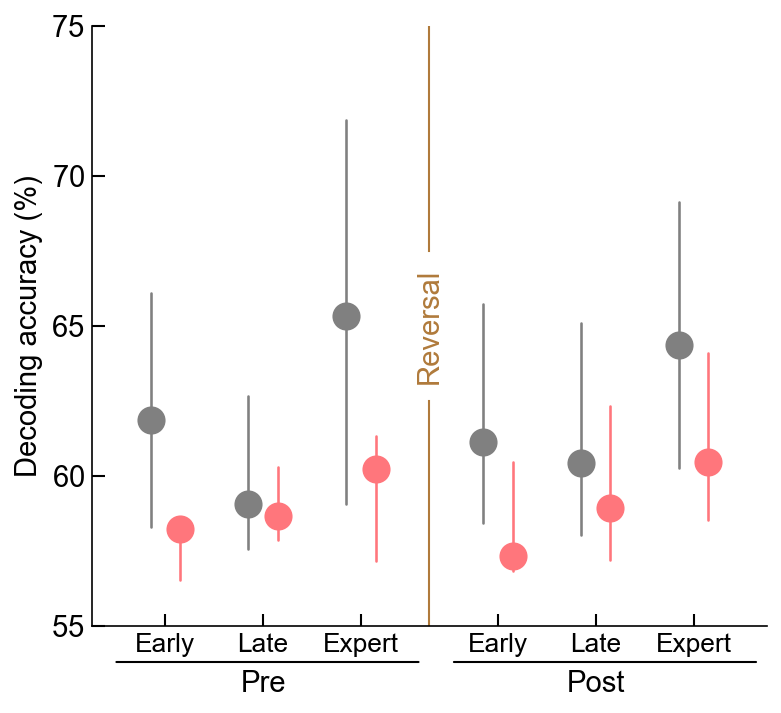

In [14]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(4.5, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.2
wid = 0.15

################################################################################################################

for idx,(CR_Stim_Dec,p) in enumerate(zip([CR_Stim_Dec_preearly,CR_Stim_Dec_prelate,CR_Stim_Dec_preexpert,CR_Stim_Dec_postearly,CR_Stim_Dec_postlate,CR_Stim_Dec_postexpert],[-1,-1,-1,1,1,1])):
    Q1, median, Q3 = (np.percentile(ilep.rmnan(CR_Stim_Dec)*100, q) for q in [25, 50, 75])
    summary_size=150
    summary_width=1.25
    eye_color=CR_COLOR
    border_color=CR_COLOR
    ax.scatter([idx-wid+p*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+-wid+p*switch_offset]*2, [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')

for idx,(NCR_Stim_Dec,p) in enumerate(zip([NCR_Stim_Dec_preearly,NCR_Stim_Dec_prelate,NCR_Stim_Dec_preexpert,NCR_Stim_Dec_postearly,NCR_Stim_Dec_postlate,NCR_Stim_Dec_postexpert],[-1,-1,-1,1,1,1])):
    Q1, median, Q3 = (np.percentile(ilep.rmnan(NCR_Stim_Dec)*100, q) for q in [25, 50, 75])
    summary_size=150
    summary_width=1.25
    eye_color=NCR_COLOR
    border_color=NCR_COLOR
    ax.scatter([idx+wid+p*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+wid+p*switch_offset]*2, [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')

################################################################################################################
labels = ['Early','Late','Expert','Early','Late','Expert']

# ax.set_ylim([45,75])
# ax.set_yticks([45,50,55,60,65,70,75])
ax.set_ylim([55,75])
ax.set_yticks([55,60,65,70,75])
ylab = ax.set_ylabel('Decoding accuracy (%)')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
# plt.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','CR NCR Decoding accuracy V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

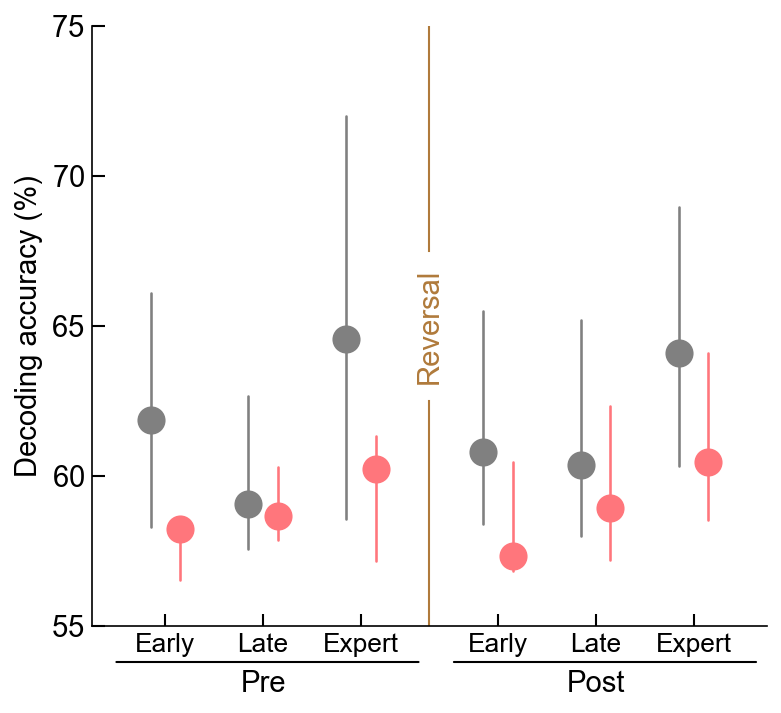

In [27]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(4.5, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.2
wid = 0.15

################################################################################################################

for idx,(CR_Stim_Dec,p) in enumerate(zip([CR_Stim_Dec_preearly,CR_Stim_Dec_prelate,CR_Stim_Dec_preexpert,CR_Stim_Dec_postearly,CR_Stim_Dec_postlate,CR_Stim_Dec_postexpert],[-1,-1,-1,1,1,1])):
    Q1, median, Q3 = (np.percentile(ilep.rmnan(CR_Stim_Dec)*100, q) for q in [25, 50, 75])
    summary_size=150
    summary_width=1.25
    eye_color=CR_COLOR
    border_color=CR_COLOR
    ax.scatter([idx-wid+p*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+-wid+p*switch_offset]*2, [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')

for idx,(NCR_Stim_Dec,p) in enumerate(zip([NCR_Stim_Dec_preearly,NCR_Stim_Dec_prelate,NCR_Stim_Dec_preexpert,NCR_Stim_Dec_postearly,NCR_Stim_Dec_postlate,NCR_Stim_Dec_postexpert],[-1,-1,-1,1,1,1])):
    Q1, median, Q3 = (np.percentile(ilep.rmnan(NCR_Stim_Dec)*100, q) for q in [25, 50, 75])
    summary_size=150
    summary_width=1.25
    eye_color=NCR_COLOR
    border_color=NCR_COLOR
    ax.scatter([idx+wid+p*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+wid+p*switch_offset]*2, [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')

################################################################################################################
labels = ['Early','Late','Expert','Early','Late','Expert']

# ax.set_ylim([45,75])
# ax.set_yticks([45,50,55,60,65,70,75])
ax.set_ylim([55,75])
ax.set_yticks([55,60,65,70,75])
ylab = ax.set_ylabel('Decoding accuracy (%)')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
# plt.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','CR NCR Decoding accuracy V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')